In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle , Circle
import seaborn as sns

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance


In [31]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

In [101]:

# gt = pd.read_csv('gt.txt',names=['frame', 'id', 'x1', 'y1', 'w', 'h', 'c_r', 'l', 'conf'])
# gt['x'], gt['y'] = ( gt.x1 + gt.x2 ) /2 , (gt.y1 + gt.y2) /2

In [115]:
gt = pd.read_csv('results.csv',names=['frame', 'id', 'x1', 'y1', 'x2', 'y2', 'c_r', 'l', 'conf','b'])
 
gt['x'], gt['y'] = ( gt.x1 + gt.x2 ) /2 , (gt.y1 + gt.y2) /2

In [116]:
gt
unique_id_count = gt['id'].nunique()
print(unique_id_count)
gt

2021


,frame,id,x1,y1,x2,y2,c_r,l,conf,b,x,y
0,0,58,-0.14,740.43,66.70,328.73,0.94,-1,-1,-1,33.280,534.580
1,0,213,560.85,163.70,73.47,199.91,0.99,-1,-1,-1,317.160,181.805
2,0,281,793.27,86.01,66.40,175.65,0.97,-1,-1,-1,429.835,130.830
3,0,329,681.41,228.04,81.61,194.28,0.99,-1,-1,-1,381.510,211.160
4,0,331,608.55,220.61,69.00,198.41,0.99,-1,-1,-1,338.775,209.510
...,...,...,...,...,...,...,...,...,...,...,...,...
116987,2331,2368,1274.43,290.66,51.43,161.45,0.72,-1,-1,-1,662.930,226.055
116988,2331,2369,495.54,387.11,64.84,163.61,0.63,-1,-1,-1,280.190,275.360
116989,2331,2348,427.18,452.44,63.56,163.20,0.54,-1,-1,-1,245.370,307.820
116990,2331,2297,986.61,232.68,54.14,134.01,0.88,-1,-1,-1,520.375,183.345


In [117]:
def transform(xy):
    H = np.array([[ 1.50888127e-03, -5.00588358e-02,  2.74125767e+01],
       [ 1.84526705e-02,  1.13249660e-02, -1.71440251e+01],
       [ 3.69061384e-05,  1.49356499e-03,  1.00000000e+00]])
    z = np.ones((xy.shape[0],1))
    xyz = np.hstack((xy, z))
    trans = H @ xyz.T
    trans[:2] = trans[:2] / trans[2]
    return trans[:2]
 
gt['x'], gt[ 'y'] = transform(gt[['x', 'y']])

In [105]:
unique_ids = gt['id'].unique()

# Select the first 50 unique IDs
selected_ids = unique_ids[:100]

# Filter the dataset to keep only rows with these 50 IDs
gt = gt[gt['id'].isin(selected_ids)]

gt

,frame,id,x1,y1,x2,y2,c_r,l,conf,b,x,y
0,0,58,-0.14,740.43,66.70,328.73,0.94,-1,-1,-1,0.390263,-5.821005
1,0,213,560.85,163.70,73.47,199.91,0.99,-1,-1,-1,14.642738,-7.194773
2,0,281,793.27,86.01,66.40,175.65,0.97,-1,-1,-1,17.759879,-6.382390
3,0,329,681.41,228.04,81.61,194.28,0.99,-1,-1,-1,13.101402,-5.801423
4,0,331,608.55,220.61,69.00,198.41,0.99,-1,-1,-1,13.155019,-6.428174
...,...,...,...,...,...,...,...,...,...,...,...,...
86545,1871,337,175.08,636.05,62.36,160.62,0.78,-1,-1,-1,4.784234,-6.529143
86614,1872,337,172.97,639.45,66.91,167.28,0.63,-1,-1,-1,4.606179,-6.448974
86684,1873,337,173.50,645.85,63.29,161.12,0.50,-1,-1,-1,4.600640,-6.465379
86751,1874,337,172.47,649.03,63.76,160.57,0.19,-1,-1,-1,4.553878,-6.451483


In [112]:
traj_len = 100  # set length of each trajectory
n_clusters = 5
XTrain = np.zeros((0, traj_len , 2) )  #
for i, g in gt.groupby('id'):  #
    traj = g[['x', 'y']].to_numpy()  #
    while traj.shape[0] >= traj_len:  # It's used to segment the trajectory into smaller parts if it's longer than traj_len
        XTrain = np.concatenate((XTrain, traj[:traj_len].reshape(1,traj_len , 2)))    #his line takes the first traj_len points from the
                                                                                        #trajectory and reshapes this segment into a 3D array with shape (1, traj_len, 2)
        traj = traj[traj_len:]




XDIFF = XTrain[:, :-1, :] - XTrain[:, 1:, :]
XDIFF = XDIFF.reshape(-1, (traj_len - 1 ) * 2)  # The result of this operation, stored in XDIFF, is a 3D NumPy array where each element [i, j, :] represents the
print(XDIFF)                                        #difference  in the x and y coordinates between the j+1th and jth points of the ith trajectory.

# scaler = MinMaxScaler()
# df_scaled = pd.DataFrame(scaler.fit_transform(XDIFF))
# print(df_scaled)
# 

[[ 0.03690678 -0.05098357  0.05917837 ...  0.03375732 -0.10307064
   0.03551781]
 [-0.0117501   0.00041022 -0.02222459 ... -0.04838669  0.05858993
  -0.04974037]
 [-0.01533801  0.00306018 -0.02580824 ... -0.02463675  0.0827452
  -0.02193333]
 ...
 [ 0.02252546 -0.01009759  0.02226174 ... -0.00845434  0.00657987
  -0.00550685]
 [ 0.03170646 -0.01333235  0.05624958 ...  0.00186948  0.02399317
  -0.00088998]
 [ 0.03047059 -0.00556446  0.03001835 ... -0.0322697   0.07773329
  -0.02885661]]


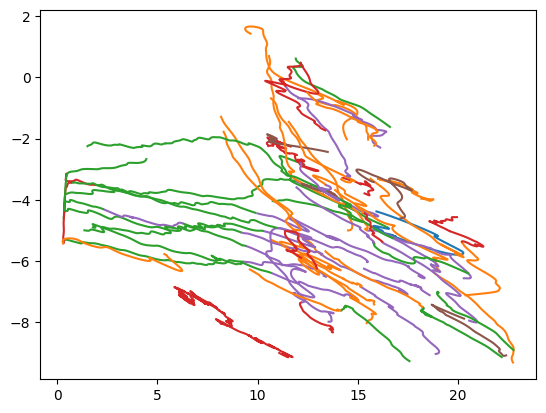

In [119]:
kmeans = cluster.KMeans(init="k-means++", n_clusters=6, n_init=7, random_state=0)
kmeans.fit(XDIFF )

centers = kmeans.cluster_centers_
y_pred = kmeans.labels_
XTrain = XTrain.reshape(-1, traj_len, 2)
for i in range(XTrain.shape[0]):
    plt.plot(XTrain[i, :, 0], XTrain[i, :, 1], c=sns.color_palette()[y_pred[i]])

In [114]:
silhouette_avg = silhouette_score(XDIFF, y_pred)

# Print the silhouette score
print("The average silhouette score is :", silhouette_avg)

The average silhouette score is : 0.12455769438091162


In [ ]:
elbow 

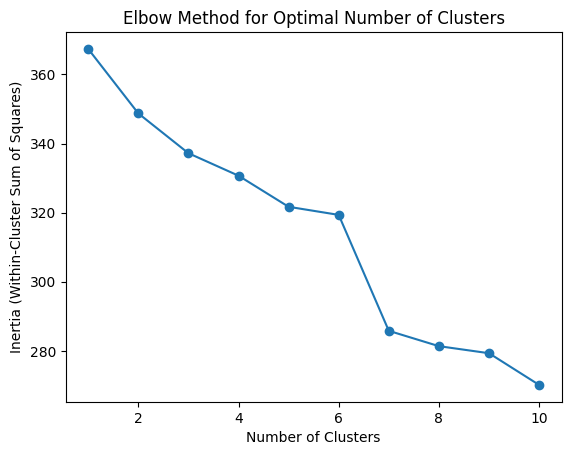

In [99]:
np.random.seed(20211231)

# Elbow method to find the optimal number of clusters
max_clusters = 10
inertia_values = []

for n_clusters in range(1, max_clusters + 1):
    kmeans = cluster.KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)
    kmeans.fit(XDIFF)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, max_clusters + 1), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

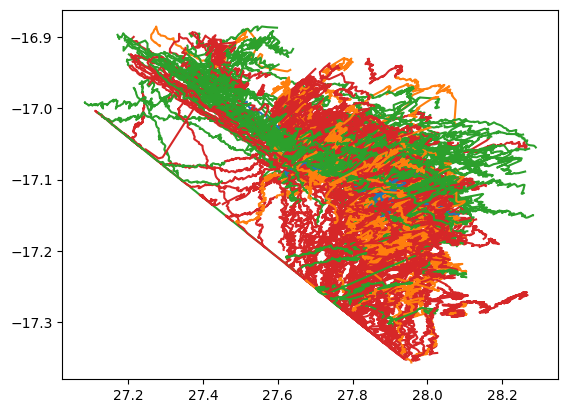

In [26]:
kmeans = cluster.KMeans(init="k-means++", n_clusters=4, n_init=4, random_state=0)
kmeans.fit(XDIFF )

centers = kmeans.cluster_centers_
y_pred = kmeans.labels_

# for plotting: 
XTrain = XTrain.reshape(-1, traj_len, 2)
for i in range(XTrain.shape[0]):
    plt.plot(XTrain[i, :, 0], XTrain[i, :, 1], c=sns.color_palette()[y_pred[i]])

For n_clusters = 2, the average silhouette_score is : 0.07867172989277113


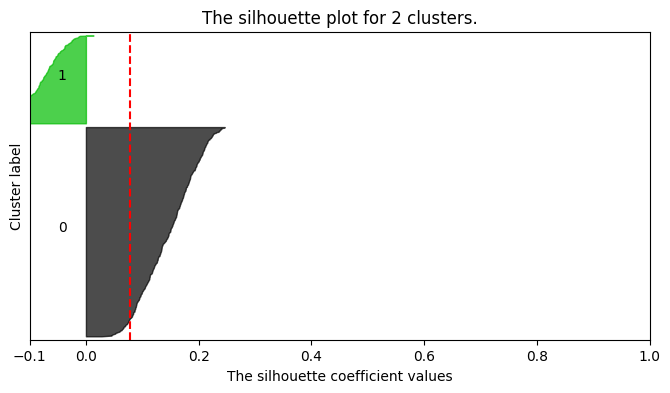

For n_clusters = 3, the average silhouette_score is : 0.0820712786540315


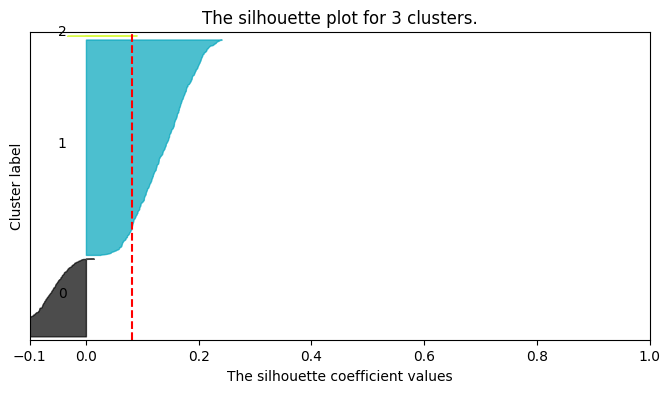

For n_clusters = 4, the average silhouette_score is : 0.051385628622696425


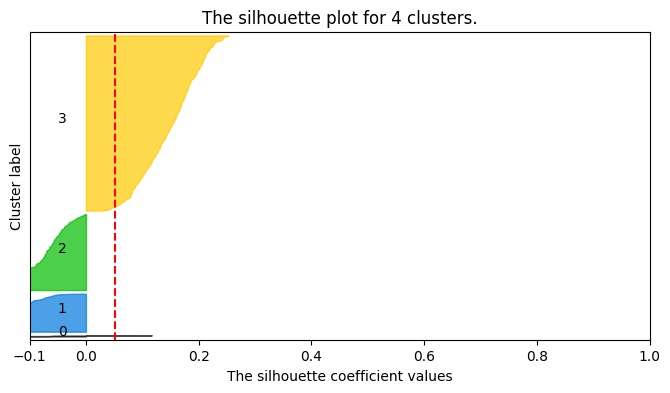

In [17]:
# Set random seed for reproducibility
np.random.seed(20211231)

# Silhouette analysis for 2, 3, and 4 clusters
cluster_range = [2, 3, 4]

for n_clusters in cluster_range:
    # Create KMeans instance
    kmeans = cluster.KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)

    # Fit the model
    cluster_labels = kmeans.fit_predict(XDIFF)

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(XDIFF, cluster_labels)
    print(f"For n_clusters = {n_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Calculate silhouette values for each data point
    sample_silhouette_values = silhouette_samples(XDIFF, cluster_labels)

    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(XDIFF) + (n_clusters + 1) * 10])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Fill the silhouette plot
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title(f"The silhouette plot for {n_clusters} clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()